In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.keras import *
from plotnine import *
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
import time
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

## Busqueda de parámetros para modelo basado en CNN con red pre-capacitada. 

### Consideraciones : 

- Esta busqueda contempla la cantidad de neuronas en una sola capa con [8,16,32,64,128,256,512] ... Hay que exploras más capas en los proximos experimentos y también el numero de neuronas para esas capas. 

- Este script de prueba considera solo una época por parámetro, pero el experimento debe ser con 100 épocas y detener el experimento luego de 10 epocas (callback EarlyStopping)

- Este experimento considera la arquitectura ResNet50, pero hay que experimentar con VGG16, Xception y Iceptionv3. 

- Este experimento considera la imagen F6 con resolución geografica de 100 metros ... Pero hay que experimentar para 6 imagenes más y con resolución geografica de 200 metros y 300 metros. 

In [113]:
np.random.seed(0)#inicilizar semilla de aletoriedad para el experimento

In [114]:
# Definir parametros y metricas de desempeño.
listParam=[8,16,32,64,128,256,512]
allRes=pd.DataFrame(np.zeros((len(listParam),13)),
    columns=["param","RMSEtrain","RMSEtest","RMSEval",
            "R2train","R2test","R2val",
            "MAEtrain","MAEtest","MAEval",
            "MSEtrain","MSEtest","MSEval"])


In [115]:
allRes

,param,RMSEtrain,RMSEtest,RMSEval,R2train,R2test,R2val,MAEtrain,MAEtest,MAEval,MSEtrain,MSEtest,MSEval
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Pre-capacitada ResNet50

In [116]:
model = ResNet50(include_top=False,input_shape=(224,224, 3))
#Setting the trainning process of the previous layer to False
for layer in model.layers:
    layer.trainable = False
print(model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [117]:
dataTrain=pd.read_csv("dataTrain_label.csv")
dataTrain

,filename,label,X,Y
0,f6_051_034.tif,0.500,208853.021150,6.082276e+06
1,f6_016_042.tif,0.000,208931.555133,6.082619e+06
2,f6_016_056.tif,0.086,209068.989602,6.082619e+06
3,f6_067_022.tif,0.276,208735.220176,6.082119e+06
4,f6_093_023.tif,0.062,208745.036924,6.081863e+06
...,...,...,...,...
1927,f6_071_042.tif,0.361,208931.555133,6.082079e+06
1928,f6_020_059.tif,0.000,209098.439846,6.082580e+06
1929,f6_030_059.tif,0.422,209098.439846,6.082482e+06
1930,f6_051_039.tif,0.838,208902.104889,6.082276e+06


In [118]:
dataTest=pd.read_csv("dataTest_label.csv")
dataTest

,filename,label,X,Y
0,f6_041_034.tif,0.465,208853.021150,6.082374e+06
1,f6_020_054.tif,0.007,209049.356107,6.082580e+06
2,f6_098_045.tif,0.000,208961.005376,6.081814e+06
3,f6_040_031.tif,0.073,208823.570907,6.082384e+06
4,f6_007_053.tif,0.000,209039.539359,6.082708e+06
...,...,...,...,...
639,f6_098_048.tif,0.000,208990.455620,6.081814e+06
640,f6_047_040.tif,0.443,208911.921637,6.082315e+06
641,f6_047_054.tif,0.000,209049.356107,6.082315e+06
642,f6_020_065.tif,0.000,209157.340333,6.082580e+06


In [119]:
dataVal=pd.read_csv("dataVal_label.csv")
dataVal

,filename,label,X,Y
0,f6_020_068.tif,0.000,209186.790576,6.082580e+06
1,f6_083_023.tif,0.070,208745.036924,6.081962e+06
2,f6_026_039.tif,0.785,208902.104889,6.082521e+06
3,f6_036_039.tif,0.413,208902.104889,6.082423e+06
4,f6_050_025.tif,0.927,208764.670420,6.082286e+06
...,...,...,...,...
639,f6_057_040.tif,0.562,208911.921637,6.082217e+06
640,f6_088_048.tif,0.000,208990.455620,6.081913e+06
641,f6_071_056.tif,0.235,209068.989602,6.082079e+06
642,f6_026_034.tif,0.000,208853.021150,6.082521e+06


## ImageDataGenerator

In [120]:
datagen = preprocessing.image.ImageDataGenerator()
datagen = preprocessing.image.ImageDataGenerator(featurewise_center=True,rotation_range=40,horizontal_flip=True,vertical_flip=True)
datagen.mean = [123.68, 116.779, 103.939]

train_it = datagen.flow_from_dataframe(dataframe=dataTrain,directory="dataset_rgb/",x_col="filename",y_col="label",batch_size=64,class_mode="raw",target_size=(224,224),shuffle=True)
test_it= datagen.flow_from_dataframe(dataframe=dataTest,directory="test/",x_col="filename",y_col="label",batch_size=64,class_mode="raw",target_size=(224,224),shuffle=True)

Found 1932 validated image filenames.
Found 644 validated image filenames.


In [121]:
def predicciones(modelo,dataset,directorio):
    predict=[]
    for i in range(len(dataset)):
        img = load_img(directorio+dataset.iloc[i,0], target_size=(224, 224))
        img = img_to_array(img)
        # reshape into a single sample with 3 channels
        img = img.reshape(1,224,224, 3)
        # center pixel data
        img = img.astype('float32')
        img = img - [123.68, 116.779, 103.939]

        result = bestmodel.predict(img)
        predict.append(result[0][0])
    return predict 

In [122]:
def metricas (real,predict):
    mse=mean_squared_error(real,predict)
    r2=r2_score(real,predict)
    rmse=np.sqrt(mean_squared_error(real,predict))
    mae=mean_absolute_error(real,predict)
    return rmse,r2,mae,mse

In [123]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

## Búsqueda de numero de neuronas en una sola capa

In [124]:
indexFinal=0 
for param in listParam:
    
    print("indice inicial:",indexFinal)
    print("Evaluacion de parametro:",param)
    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience= 1,mode='min')
    checkpoint=callbacks.ModelCheckpoint("bestModel_Resnet_%s.hdf5"%param,monitor='val_loss',save_best_only=True,mode='min')
    flat1 = layers.Flatten()(model.layers[-1].output)
    class1 = layers.Dense(param, activation='sigmoid')(flat1)
    output = layers.Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    model.compile(optimizer=opt, loss='mse', metrics=["mean_squared_error","mean_absolute_error"])
    start_time = time.time()
    history = model.fit(train_it, steps_per_epoch=len(train_it),validation_data=test_it, validation_steps=len(test_it), epochs=1, verbose=1,callbacks = [checkpoint,early_stopping])
    
    
    ## evalución de modelo 
    bestmodel = load_model("bestModel_Resnet_%s.hdf5"%param)
    predic_train=predicciones(bestmodel,dataTrain,"dataset_rgb/")#evaluacion train
    predic_test=predicciones(bestmodel,dataTest,"test/") # evaluacion test 
    predic_val=predicciones(bestmodel,dataVal,"validation/")#evaluacion val
    
    desem_train = metricas(dataTrain.iloc[:,1],predic_train)
    desem_test= metricas(dataTest.iloc[:,1],predic_test)
    desem_val= metricas(dataVal.iloc[:,1],predic_val)
    
    #print("Desempeño train : ",desem_train)
    #print("Desempeño test : ",desem_test)
    #print("Desempeño validacion : ",desem_val)
    
    allRes.iloc[indexFinal,0]=param
    allRes.iloc[indexFinal,1]=desem_train[0]#rmse
    allRes.iloc[indexFinal,2]=desem_test[0]
    allRes.iloc[indexFinal,3]=desem_val[0]
    
    allRes.iloc[indexFinal,4]=desem_train[1]#r2
    allRes.iloc[indexFinal,5]=desem_test[1]
    allRes.iloc[indexFinal,6]=desem_val[1]

    allRes.iloc[indexFinal,7]=desem_train[2]#mae
    allRes.iloc[indexFinal,8]=desem_test[2]
    allRes.iloc[indexFinal,9]=desem_val[2]

    allRes.iloc[indexFinal,10]=desem_train[3]#mse
    allRes.iloc[indexFinal,11]=desem_test[3]
    allRes.iloc[indexFinal,12]=desem_val[3]
    indexFinal+=1 
    seg=time.time() - start_time
    
  

indice inicial: 0
Evaluacion de parametro: 8
31/31 [==============================] - 125s 4s/step - loss: 0.0731 - mean_squared_error: 0.0731 - mean_absolute_error: 0.2360 - val_loss: 0.0711 - val_mean_squared_error: 0.0711 - val_mean_absolute_error: 0.2302
indice inicial: 1
Evaluacion de parametro: 16
31/31 [==============================] - 113s 4s/step - loss: 0.1375 - mean_squared_error: 0.1375 - mean_absolute_error: 0.3294 - val_loss: 0.1309 - val_mean_squared_error: 0.1309 - val_mean_absolute_error: 0.3207
indice inicial: 2
Evaluacion de parametro: 32
31/31 [==============================] - 111s 4s/step - loss: 0.2619 - mean_squared_error: 0.2619 - mean_absolute_error: 0.4583 - val_loss: 0.2476 - val_mean_squared_error: 0.2476 - val_mean_absolute_error: 0.4441
indice inicial: 3
Evaluacion de parametro: 64
31/31 [==============================] - 114s 4s/step - loss: 0.0890 - mean_squared_error: 0.0890 - mean_absolute_error: 0.2664 - val_loss: 0.0834 - val_mean_squared_error: 0.

## Dataframe con metricas de resultado para los parametros explorados

In [126]:
allRes

,param,RMSEtrain,RMSEtest,RMSEval,R2train,R2test,R2val,MAEtrain,MAEtest,MAEval,MSEtrain,MSEtest,MSEval
0,8.0,0.266802,0.266728,0.259638,-0.027863,-0.016580,-0.036388,0.233140,0.230209,0.225976,0.071183,0.071144,0.067412
1,16.0,0.367586,0.361836,0.365098,-0.951075,-0.870796,-1.049292,0.326529,0.320742,0.325484,0.135119,0.130925,0.133297
2,32.0,0.505183,0.497595,0.504971,-2.685138,-2.537982,-2.920289,0.452056,0.444074,0.453882,0.255210,0.247601,0.254996
3,64.0,0.291597,0.288786,0.286354,-0.227781,-0.191670,-0.260637,0.260193,0.256836,0.255092,0.085029,0.083397,0.081998
4,128.0,0.330215,0.325524,0.326638,-0.574528,-0.514154,-0.640284,0.294427,0.289197,0.291115,0.109042,0.105966,0.106693
5,256.0,0.300088,0.296745,0.295287,-0.300328,-0.258257,-0.340517,0.267988,0.264196,0.263294,0.090053,0.088057,0.087194
6,512.0,0.272941,0.271856,0.266414,-0.075704,-0.056044,-0.091185,0.241240,0.237798,0.234538,0.074497,0.073906,0.070976


## Tiempo de trabajo 

In [137]:
hora=seg/3600
hora

0.22995196998119355

### Grafico para comparar metricas 

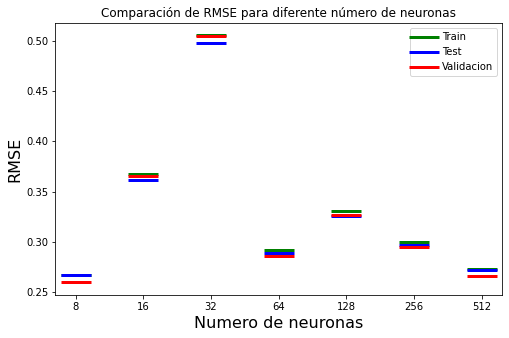

In [184]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(10,allRes.iloc[0,1],marker ="_",markersize=30,markeredgewidth=3,color='green',label="Train")
plt.plot(10,allRes.iloc[0,2],marker ="_",markersize=30,markeredgewidth=3,color='blue',label="Test")
plt.plot(10,allRes.iloc[0,3],marker ="_",markersize=30,markeredgewidth=3,color='red',label="Validacion")

plt.plot(20,allRes.iloc[1,1],marker ="_",markersize=30,markeredgewidth=3,color='green')
plt.plot(20,allRes.iloc[1,2],marker ="_",markersize=30,markeredgewidth=3,color='blue')
plt.plot(20,allRes.iloc[1,3],marker ="_",markersize=30,markeredgewidth=3,color='red')

plt.plot(30,allRes.iloc[2,1],marker ="_",markersize=30,markeredgewidth=3,color='green')
plt.plot(30,allRes.iloc[2,2],marker ="_",markersize=30,markeredgewidth=3,color='blue')
plt.plot(30,allRes.iloc[2,3],marker ="_",markersize=30,markeredgewidth=3,color='red')

plt.plot(40,allRes.iloc[3,1],marker ="_",markersize=30,markeredgewidth=3,color='green')
plt.plot(40,allRes.iloc[3,2],marker ="_",markersize=30,markeredgewidth=3,color='blue')
plt.plot(40,allRes.iloc[3,3],marker ="_",markersize=30,markeredgewidth=3,color='red')

plt.plot(50,allRes.iloc[4,1],marker ="_",markersize=30,markeredgewidth=3,color='green')
plt.plot(50,allRes.iloc[4,2],marker ="_",markersize=30,markeredgewidth=3,color='blue')
plt.plot(50,allRes.iloc[4,3],marker ="_",markersize=30,markeredgewidth=3,color='red')

plt.plot(60,allRes.iloc[5,1],marker ="_",markersize=30,markeredgewidth=3,color='green')
plt.plot(60,allRes.iloc[5,2],marker ="_",markersize=30,markeredgewidth=3,color='blue')
plt.plot(60,allRes.iloc[5,3],marker ="_",markersize=30,markeredgewidth=3,color='red')

plt.plot(70,allRes.iloc[6,1],marker ="_",markersize=30,markeredgewidth=3,color='green')
plt.plot(70,allRes.iloc[6,2],marker ="_",markersize=30,markeredgewidth=3,color='blue')
plt.plot(70,allRes.iloc[6,3],marker ="_",markersize=30,markeredgewidth=3,color='red')

x=[10,20,30,40,50,60,70]
values = ['8', '16', '32', '64','128','256','512'] 
plt.xticks(x,values)
plt.xlabel("Numero de neuronas", size = 16)
plt.ylabel("RMSE", size = 16)
plt.title('Comparación de RMSE para diferente número de neuronas')
plt.legend()
plt.show()
